Process for CVQC

In [1]:
import csv
import time
import random
import numpy as np
import networkx as nx
import strawberryfields as sf
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from strawberryfields import ops
from itertools import combinations
from strawberryfields.apps import data, qchem, plot
from strawberryfields.utils import random_interferometer
from strawberryfields.apps.similarity import feature_vector_orbits_sampling

Step1: Mapping

In [2]:
# function that take a raw matrix and k (number of columns) and n (the nth number you want to compare) value in, return the best k columns
def find_best_k_combination(matrix, k, n):
    # get all possible combination
    num_columns = matrix.shape[1]
    column_combinations = combinations(range(num_columns), k)
        
#     column_combinations = get_column_combinations(matrix, k)
    
    strength = []
    Combination = []

    for combination in column_combinations:
        Combination.append(combination)
        selected_columns = matrix[:, combination]
        # calculate the row abs square sum
        row_sums = np.sum(np.abs(selected_columns) ** 2, axis=1)
        # make it decrease
        sorted_indices = np.argsort(row_sums)[::-1]
        sorted_row_sums = row_sums[sorted_indices]
        val = sorted_row_sums[n-1]
        strength.append(val)

    largest_value = np.max(strength)
    largest_index = np.argmax(strength)

    # find the best combination
    best_combination = Combination[largest_index]
    best_selected_columns = matrix[:, best_combination]

    return best_selected_columns

In [3]:
# final function, recieve the original matrix and a list of len, also n (the nth number you want to compare), return the permuted matrix
# U = row_per_matrix*U'*col_per_matrix
def mapping(U, len_list, n):
    
    M, N = U.shape
    total_len = sum(len_list)
    assert N == total_len
    
    # copy U
    U_t = U.copy()
#     print(U)
    
    # new column permutation
    for i, length in enumerate(len_list):
        if i<len(len_list)-1:
            U_new = U_t[:,:length].copy()
#             print("i:", i)
            # calculate the row abs square sum
            row_sums = np.sum(np.abs(U_new) ** 2, axis=1)
            U_new_update = U_new.copy()
            # iterate remain column
            for j in range(np.sum(len_list[i+1:])):
#                 print("j:", j)
                for k in range(length):
#                     print("k:", k)
                    U_new_update_k = U_new_update[:,k].copy()
                    U_new_update[:,k] = U_t[:,length+j].copy()
                    # calculate the row abs square sum
                    row_sums_update = np.sum(np.abs(U_new_update) ** 2, axis=1)
                
                    if np.sort(row_sums_update)[::-1][n-1] > np.sort(row_sums)[::-1][n-1]:
#                     row_sums_update[n-1] > row_sums[n-1]:
                        U_new = U_new_update.copy()
                        U_t[:,length+j] = U_new_update_k.copy()
                        U_t[:,:length] = U_new.copy()
                        row_sums = row_sums_update
                    else:
                        U_new_update = U_new.copy()

            
            # add U_new to U_per
            if i==0:
                U_per = U_new.copy()
            elif i==len(len_list)-2:
                U_per = np.hstack((U_per, U_t)).copy()
            else:
                U_per = np.hstack((U_per, U_new)).copy()

            
            # drop U_new from U_t
            U_t = U_t[:,length:].copy()
        
                    

#     for i, length in enumerate(len_list):
#         U_new = find_best_k_combination(U_t, length, n)
        
#         # Find column indices in the larger matrix corresponding to the smaller matrix
#         selected_columns = []
#         for col in range(U_new.shape[1]):
#             for j in range(U_t.shape[1]):
#                 if np.array_equal(U_new[:, col], U_t[:, j]):
#                     selected_columns.append(j)
#                     break

#         # drop U_new from U_t
#         U_t = np.delete(U_t, selected_columns, axis=1)
        
#         # add U_new to U_per
#         if i==0:
#             U_per = U_new
#         else:
#             U_per = np.hstack((U_per, U_new))
      
      
    # find the permutation from U_per to U
    col_permutation = []
    for col in range(U_per.shape[1]):
        for i in range(U.shape[1]):
            if np.array_equal(U_per[:, col], U[:, i]):
                col_permutation.append(i)
                break
                
    # find the columns permutation matrix
    col_per_matrix = np.zeros((N, N))
    for i in range(N):
        col_per_matrix[col_permutation[i], i] = 1
        


    # calculate the sum of first len for U_per
    selected_columns = U_per[:, :len_list[0]] 
    # calculate the row abs square sum
    row_sums = np.sum(np.abs(selected_columns) ** 2, axis=1)
    
    # decide the row rotation
    sorted_indices = np.argsort(row_sums)
    U_per_new = U_per[sorted_indices]
    
    # Find row permutation
    row_permutation = []
    for row in range(U_per_new.shape[0]):
        for i in range(U_per.shape[0]):
            if np.array_equal(U_per_new[row, :], U_per[i, :]):
                row_permutation.append(i)
                break
                
    # find the rows permutation matrix
    row_per_matrix = np.zeros((M, M))
    for i in range(M):
        row_per_matrix[i, row_permutation[i]] = 1
        
    
    U_final = U_per_new
    
    # U_final = U_per, out put U_final and the permutation
    return U_final, col_per_matrix.T, row_per_matrix.T

Step2: Matrix Decomposition

In [4]:
# Define the left eliminate equations
def left_equations(variables,parameters):
    theta, phi = variables
    a_r, a_i, b_r, b_i = parameters
    eq1 = a_r * np.cos(phi) * np.cos(theta) + a_i * np.sin(phi) * np.cos(theta) - b_r * np.sin(theta)
    eq2 = a_i * np.cos(phi) * np.cos(theta) - a_r * np.sin(phi) * np.cos(theta) - b_i * np.sin(theta)
    return [eq1, eq2]

# function of left elimination
def left_elimination(a,b):
    a_r = np.real(a)
    a_i = np.imag(a)
    b_r = np.real(b)
    b_i = np.imag(b)
    
    # Solve the system of equations
    initial_guess = [0, 0]  # Initial guess for the variables
    parameters = [a_r, a_i, b_r, b_i]
    raw_solution = fsolve(left_equations, initial_guess, args=(parameters,))
    
    
    if np.abs(a_r) < 1e-8 and np.abs(b_i) < 1e-8:
            raw_solution = [np.arctan(a_i/b_r), np.pi/2]
        
    if np.abs(a_i) < 1e-8 and np.abs(b_r) < 1e-8:
            raw_solution = [np.arctan(-a_r/b_i), np.pi/2]
            
            
    if np.abs(b_r) < 1e-8 and np.abs(b_i) < 1e-8:
            raw_solution = [np.pi/2, 0]
    
    
    normalized_solution = [angle % (2 * np.pi) for angle in raw_solution]
    solution = []
    for angle in normalized_solution:
        if angle < np.pi:
            solution.append(angle)
        else:
            solution.append(angle-2*np.pi)

    # Print the solution
#     print("Solution:", solution)
    return solution

In [5]:
# Define the right eliminate equations
def right_equations(variables,parameters):
    theta, phi = variables
    a_r, a_i, b_r, b_i = parameters
    eq1 = a_r * np.cos(phi) * np.sin(theta) + a_i * np.sin(phi) * np.sin(theta) + b_r * np.cos(theta)
    eq2 = a_i * np.cos(phi) * np.sin(theta) - a_r * np.sin(phi) * np.sin(theta) + b_i * np.cos(theta)
    return [eq1, eq2]

# function of right elimination
def right_elimination(a,b):
    a_r = np.real(a)
    a_i = np.imag(a)
    b_r = np.real(b)
    b_i = np.imag(b)
    
    # Solve the system of equations
    initial_guess = [0, 0]  # Initial guess for the variables
    parameters = [a_r, a_i, b_r, b_i]
    raw_solution = fsolve(right_equations, initial_guess, args=(parameters,))
    
    if np.abs(a_r) < 1e-8 and np.abs(b_i) < 1e-8:
        raw_solution = [np.arctan(-b_r/a_i), np.pi/2]
        
    if np.abs(a_i) < 1e-8 and np.abs(b_r) < 1e-8:
        raw_solution = [np.arctan(b_i/a_r), np.pi/2]
        
    if np.abs(a_r) < 1e-8 and np.abs(a_i) < 1e-8:
        raw_solution = [np.pi/2, 0]
    
    normalized_solution = [angle % (2 * np.pi) for angle in raw_solution]
    solution = []
    for angle in normalized_solution:
        if angle < np.pi:
            solution.append(angle)
        else:
            solution.append(angle-2*np.pi)

    # Print the solution
#     print("Solution:", solution)
    return solution

In [6]:
# give rotation matrix with idx_1 < idx_2
def rotation(theta, phi, n, idx_1, idx_2):
    I = np.eye(n, dtype=complex)
    I[idx_1,idx_1] = np.cos(theta)*(np.cos(phi)-np.sin(phi)*1j)
    I[idx_1,idx_2] = np.sin(theta)*(np.cos(phi)-np.sin(phi)*1j)
    I[idx_2,idx_1] = -np.sin(theta)
    I[idx_2,idx_2] = np.cos(theta)
    
    return I

In [7]:
# matrix permutation
def permutation(U):
    
    rows, columns = U.shape
    assert(rows==columns)
    
    # create the permutation matrix
    Permutation = np.zeros([rows,columns])
    
    diag_U = np.eye(rows, dtype=complex)
    
    indices = np.nonzero(U)
    row_info = indices[0]
    col_info = indices[1]
    
    for i in range(rows):
        col = col_info[i]
        row = row_info[i]
        diag_U[col,:] = U[row,:]
        Permutation[col,row] = 1
        
    return diag_U, Permutation.T

In [8]:
def phase(x):
    x_r = np.real(x)
    x_i = np.imag(x)
    
    raw_phi = np.arccos(x_r)
    if x_i > 0:
        t_phi = raw_phi
    else:
        t_phi = -raw_phi
        
    normalized_solution = t_phi % (2 * np.pi)
    if normalized_solution > np.pi:
        normalized_solution = normalized_solution-2*np.pi

    return normalized_solution

In [9]:
# the all_list tell the decomposition order
# [[1,2], [2,3], [3,4]] means first use 2 eliminate 1, then use 3 eliminate 2, then use 4 eliminate 3
def U_decompose_plus(U, all_list):
    
    # pick up a machine precision
    threshold = 1e-8
    
    # get the shape of unitary
    rows, columns = U.shape
    assert(rows==columns)
    
    # create the rotation record matrix, the first row for theta, the second row for phi 
    # third row for low index, forth row for high index
    Theta = []
    Phi = []
    Low_idx = []
    High_idx = []
    
    # create the diagonal record matrix
    Diag = []
    

    for i in range(rows-1, 0, -1):
        list_i = all_list[i-1]
        row = U[i, :]
        
        for j in range(i):
            pair = list_i[j]
            
            
            # a is the number to be eliminated, b is the number to eliminate the previous one
            a = row[pair[0]]
            b = row[pair[1]]
            
            
#             if i % 3 != 0:
#                 if j == i-1:
#                     a = row[pair[1]]
#                     b = row[pair[0]]
                
                
            # choose the elimination method by position
            if pair[0] < pair[1]: 
                theta, phi = left_elimination(a,b)

                # write down the parameter
                Theta.append(theta)
                Phi.append(phi)
                Low_idx.append(pair[0])
                High_idx.append(pair[1])

                # create the rotation
                r = rotation(theta, phi, rows, pair[0], pair[1])
        

                # update Unitary
                U = np.dot(U, r)
                U= np.where(np.abs(U) < threshold, 0, U)

            else:
                theta, phi = right_elimination(b,a)

                # write down the parameter
                Theta.append(theta)
                Phi.append(phi)
                Low_idx.append(pair[1])
                High_idx.append(pair[0])

                # create the rotation
                r = rotation(theta, phi, rows, pair[1], pair[0])

                # update Unitary
                U = np.dot(U, r)
                U= np.where(np.abs(U) < threshold, 0, U)

            row = U[i, :]
            
#             if (np.count_nonzero(row) == 1):
            if j == i-1:
                entry = U[i, pair[1]]
                U[:, pair[1]] = 0
                U[i, :] = 0
                U[i, pair[1]] = entry
                flag = 0
    
    # do the permutation, and record
    U, Permutation = permutation(U)
    
    # find the phase shift
    for i in range(rows):
        x = U[i,i]/np.abs(U[i,i])
        phi_x = phase(x)
        Diag.append(phi_x)
        U[i,i] = U[i,i]*(np.cos(phi_x)-np.sin(phi_x)*1j)
    
    
    return U, Theta, Phi, Low_idx, High_idx, Diag, Permutation

Step3: Drift Method

In [10]:
# Step1 probability
def calculate_probability_sequence(angles, threshold, N):
    abs_angles = np.abs(angles)
    angles1 = abs_angles/(threshold)
    angles2 = angles1**N
    total_magnitude = np.sum(angles2)
    probabilities = angles2 / total_magnitude
    return probabilities

In [11]:
# sequence is the origianl angel sequence, probability is calculate using calculate_probability_sequence(angles), percentage is the proportion you want to preserve
def pick_entries_with_indices(sequence, probabilities, proportion):
    
    N = len(sequence)
    num_entries = np.floor(N*proportion).astype(int)
    
    idx_sequence = np.arange(N).astype(int)
    
    if np.count_nonzero(sequence) < num_entries:
        num_entries = np.count_nonzero(sequence)
    
    picked_indices = np.random.choice(idx_sequence, size=num_entries, replace=False, p=probabilities)
    picked_entries = [sequence[index] for index in picked_indices]

    # Sort the picked entries and indices based on the indices
    picked_entries, picked_indices = zip(*sorted(zip(picked_entries, picked_indices), key=lambda x: x[1]))
    
    modified_sequence = [entry if index in picked_indices else 0 for index, entry in enumerate(sequence)]

    return modified_sequence

Step4: Matric Reconstruction

In [12]:
def make_entries_zero(Array, threshold):
    array = Array.copy()
    for i in range(len(array)):
        if np.abs(array[i]) < threshold:
            array[i] = 0
    return array

In [13]:
# give rotation matrix with idx_1 < idx_2
def reconstruct_rotation(theta, phi, n, idx_1, idx_2):
    I = np.eye(n, dtype=complex)
    I[idx_1,idx_1] = np.cos(theta)*(np.cos(phi)+np.sin(phi)*1j)
    I[idx_1,idx_2] = -np.sin(theta)
    I[idx_2,idx_1] = np.sin(theta)*(np.cos(phi)+np.sin(phi)*1j)
    I[idx_2,idx_2] = np.cos(theta)
    
    return I

In [14]:
def matrix_reconstruct(Theta, Phi, Low_idx, High_idx, Diag, Permutation, N):
    
    M = len(Theta)
    
    per_theta = (len([x for x in Theta if np.abs(x) == 0]) / len(Theta)) * 100
#     print("theta reduce")
#     print(per_theta)
    
    per_phi = (len([x for x in Phi if np.abs(x) == 0]) / len(Phi)) * 100
#     print("phi reduce")
#     print(per_phi)

#     new_theta = Theta
#     new_phi = Phi
    
    V = np.eye(N, dtype=complex)
    
    # rotation
    for i in range(M):
        r = reconstruct_rotation(Theta[i], Phi[i], N, Low_idx[i], High_idx[i])
        V = np.dot(r, V)
        
    # phase shift
    for i in range(N):
        V[i,:] = V[i,:]*(np.cos(Diag[i])+np.sin(Diag[i])*1j)
        
    # permutation
    V = np.dot(Permutation, V)
    
    return V

Accuracy

In [15]:
# function to calculate the approximation accuracy
def accuracy(U,U_app):
    I = np.dot(U,np.conjugate(U_app).transpose())
    N, N = I.shape
    acc = np.trace(I)/N
    return acc

In [16]:
def distance_between_vectors(v1, v2):
    distance = np.linalg.norm(v1 - v2)
    return distance

Reduce counting

In [17]:
def count_numbers_less_than(numbers, threshold):
    count = 0
    for number in numbers:
        if np.abs(number) < threshold:
            count += 1
    return count

Step5: Sampling Vibrational Molecule

In [18]:
# define the sampleing function
# M is the total sampling numbers
# r, U2, alpha is the transition matrix, since Temperature is zero array
# dec_list: a list give the decomposition order  
# mapping: "on" or "off", coreesponding to 1 or 0
# len_list: a list for mapping
# n: a compare number for mapping
# all_modes: (q[0], ..., q[N-1])
# proportion: 0~1 for U2
# loss is the photon number loss
# qdrift_kind: 0: defualt, 1:cut
def vibration_sampling_plus(M, S, S_model, U, dec_list, maps, len_list, n, proportion, threshold, N, loss):
    
    N, N = U.shape
    
    S_max = np.max(S)
    S = S/(S_max+S_model)
    S = np.arctanh(S)

    
    # mapping
    if maps:
        U_map, col_per_matrix, row_per_matrix = mapping(U, len_list, n)
    else:
        U_map = U
        col_per_matrix = np.eye(N)
        row_per_matrix = np.eye(N)
    
    # get the decomposition information of U
    _, Theta, Phi, Low_idx, High_idx, Diag, Permutation = U_decompose_plus(U_map, dec_list)
    
    # modify Theta
    Theta_prob = calculate_probability_sequence(Theta, threshold, N)
    
    
    k = 0
    sample = []
    acc = []
    while k < M:
#         if k % 1 == 0:
#             print(k)
        
        # get the new Theta from the probability distribution
        new_Theta = pick_entries_with_indices(Theta, Theta_prob, proportion)
        new_Phi = Phi
        
        # reconstruction of U using new angel
        U_map_app = matrix_reconstruct(new_Theta, new_Phi, Low_idx, High_idx, Diag, Permutation, N)
        # approximation accuracy
        acc_t = accuracy(U_map,U_map_app)
        acc.append(acc_t)
        

#         print("here")
        # construct the circuit
        prog = sf.Program(N)
        eng = sf.Engine('gaussian')
        with prog.context as q:
            
            # r squeezing
            for i, s in enumerate(S):
                ops.Sgate(s) | q[i]
            
            # mapping's column transformation
            ops.Interferometer(col_per_matrix) | (q[0], q[1], q[2], q[3], q[4], q[5], q[6], q[7], q[8], q[9], q[10], q[11], q[12], q[13], q[14], q[15], q[16], q[17], q[18], q[19], q[20], q[21], q[22], q[23])
            
            
            # interferometer U
            for i in range(len(new_Theta)):
                ops.Rgate(new_Phi[i])       | q[Low_idx[i]]
                ops.BSgate(new_Theta[i], 0) | (q[Low_idx[i]], q[High_idx[i]])
                if np.abs(new_Theta[i]) > 0:
                    ops.LossChannel(loss) | q[Low_idx[i]]
                    ops.LossChannel(loss) | q[High_idx[i]]
                
            for i in range(N):
                ops.Rgate(Diag[i])       | q[i]
                
                
            # mapping's row transformation
            ops.Interferometer(row_per_matrix) | (q[0], q[1], q[2], q[3], q[4], q[5], q[6], q[7], q[8], q[9], q[10], q[11], q[12], q[13], q[14], q[15], q[16], q[17], q[18], q[19], q[20], q[21], q[22], q[23])
            
            
            # measurement
            ops.MeasureFock() | q
            

        
        results = eng.run(prog, shots=1)
        sample_t = results.samples
        sample.append(sample_t[0])
#         print("here")
        
        k = k+1
    
    # manipulate the samples
    zero = np.zeros(N)
    for i in range(len(sample)):
        sample[i] = np.concatenate((sample[i], zero))
    sample_list = []
    for a in sample:
        b = list(a)
        c = [int(num) for num in b]
        sample_list.append(c)

    acc_mean = np.mean(acc)
#     print("mean accuracy for U:", acc_mean)
        
    return sample_list

dec_list1: 1D

In [19]:
list_order = [[0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,8], [8,9], [9,10], [10,11], [11,12], [12,13], [13,14], [14,15], [15,16], [16,17], [17,18], [18,19], [19,20], [20,21], [21,22], [22,23]]
dec_list1 = [list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order]

len_list1: 1D

In [20]:
len_list1 = [24]

dec_list2: 2D

In [21]:
list_order23 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [21,7], [7,8], [22,8], [8,23]]
list_order22 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [21,7], [7,8], [8,22]]
list_order21 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [21,7], [7,8]]
list_order20 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [7,21]]
list_order19 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [7,20]]
list_order18 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7]]
list_order17 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5], [16,5], [17,5], [5,6], [18,6], [6,19]]
list_order16 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5], [16,5], [17,5], [5,6], [6,18]]
list_order15 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5], [16,5], [17,5], [5,6]]
list_order14 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5], [16,5], [5,17]]
list_order13 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5], [5,16]]
list_order12 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [15,4], [4,5]]
list_order11 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [14,4], [4,15]]
list_order10 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4], [4,14]]
list_order9 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [11,3], [3,4]]
list_order8 = [[0,1], [9,1], [1,2], [10,2], [2,3], [13,12], [12,3], [3,11]]
list_order7 = [[0,1], [9,1], [1,2], [10,2], [2,3], [3,12], [12,13]]
list_order6 = [[0,1], [9,1], [1,2], [10,2], [2,3], [3,12]]
list_order5 = [[0,1], [9,1], [1,2], [10,2], [2,3]]
list_order4 = [[0,1], [9,1], [1,2], [2,10]]
list_order3 = [[0,1], [9,1], [1,2]]
list_order2 = [[0,1], [1,9]]
list_order1 = [[0,1]]


dec_list2 = [list_order1, list_order2, list_order3, list_order4, list_order5, list_order6, list_order7, list_order8, list_order9, list_order10, list_order11, list_order12, list_order13, list_order14, list_order15, list_order16, list_order17, list_order18, list_order19, list_order20, list_order21, list_order22, list_order23]

len_list2: 2D

In [22]:
len_list2 = [9,1,1,2,1,1,1,1,1,1,1,1,1,1,1]

Generate graph

In [23]:
def generate_random_graph(nodes, probability):
    G = nx.Graph()
    G.add_nodes_from(nodes)

    for i in nodes:
        for j in nodes:
            if i != j and random.random() < probability:
                G.add_edge(i, j)

    return G

In [24]:
# Generate G
# G1 = generate_random_graph(range(24), 0.7)
# G2 = generate_random_graph(range(24), 0.875)

In [25]:
# # Write the graph as an adjacency list
# nx.write_adjlist(G1, "graph_sim1_new.adjlist")
# nx.write_adjlist(G2, "graph_sim2_new.adjlist")

# Read the graph from the adjacency list
G1 = nx.read_adjlist("graph_sim1.adjlist")
        
G2 = nx.read_adjlist("graph_sim2.adjlist")

In [26]:
# Obtain the adjacency matrix of the graph G
A1 = nx.to_numpy_array(G1)

A2 = nx.to_numpy_array(G2)

In [27]:
S1, U1 = sf.decompositions.takagi(A1)

S2, U2 = sf.decompositions.takagi(A2)

In [28]:
S1, U1 = sf.decompositions.takagi(A1)
S1_max = np.max(S1)
S1 = S1/(S1_max+0.3324)

In [29]:
S2, U2 = sf.decompositions.takagi(A2)
S2_max = np.max(S2)
S2 = S2/(S2_max+0.351)

In [30]:
n1 = 0
for s in S1:
    n1 = n1+s**2/(1-s**2)
print(n1)

32.00466204633247


In [31]:
n2 = 0
for s in S2:
    n2 = n2+s**2/(1-s**2)
print(n2)

32.00972502839568


Sampling

In [32]:
G1_acc1 = []
G1_acc2 = []
G1_acc3 = []
G1_acc4 = []
G2_acc1 = []
G2_acc2 = []
G2_acc3 = []
G2_acc4 = []

In [33]:
time_base = []
sample_G1_base = []
sample_G2_base = []
vector_G1_base = []
vector_G2_base = []

/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: divide by zero encountered in scalar divide
/home/ubuntu/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: invalid value encountered in scalar divide


[0.024, 0.0714, 0.198]
[0.0231, 0.0706, 0.1958]
[0.0227, 0.0678, 0.199]
[0.0203, 0.0712, 0.1933]
[0.022, 0.0711, 0.187]
[0.0195, 0.0699, 0.1943]


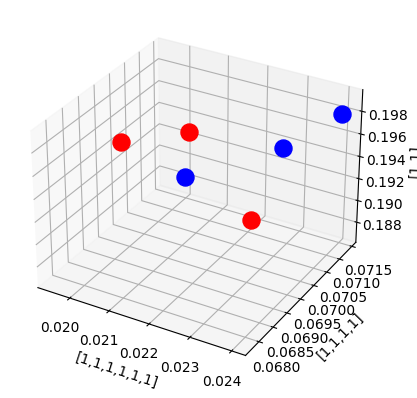

In [34]:
# base experiments
M_base = 10000
loss = 1


start_time = time.time()
sample_list1 = vibration_sampling_plus(M_base, S1, 0.3324, U1, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
sample_list2 = vibration_sampling_plus(M_base, S1, 0.3324, U1, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
sample_list3 = vibration_sampling_plus(M_base, S1, 0.3324, U1, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
end_time = time.time()
execution_time = end_time - start_time
time_base.append(execution_time)
sample_G1_base.append(sample_list1)
sample_G1_base.append(sample_list2)
sample_G1_base.append(sample_list3)

start_time = time.time()
sample_list4 = vibration_sampling_plus(M_base, S2, 0.351, U2, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
sample_list5 = vibration_sampling_plus(M_base, S2, 0.351, U2, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
sample_list6 = vibration_sampling_plus(M_base, S2, 0.351, U2, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
end_time = time.time()
execution_time = end_time - start_time
time_base.append(execution_time)
sample_G2_base.append(sample_list4)
sample_G2_base.append(sample_list5)
sample_G2_base.append(sample_list6)

orbits = [[1,1,1,1,1,1], [1,1,1,1], [1,1]]
vector1 = feature_vector_orbits_sampling(sample_list1, orbits)
vector2 = feature_vector_orbits_sampling(sample_list2, orbits)
vector3 = feature_vector_orbits_sampling(sample_list3, orbits)
vector4 = feature_vector_orbits_sampling(sample_list4, orbits)
vector5 = feature_vector_orbits_sampling(sample_list5, orbits)
vector6 = feature_vector_orbits_sampling(sample_list6, orbits)

vector_G1_base.append(vector1)
vector_G1_base.append(vector2)
vector_G1_base.append(vector3)
vector_G2_base.append(vector4)
vector_G2_base.append(vector5)
vector_G2_base.append(vector6)

G1_base = (np.array(vector1)+np.array(vector2)+np.array(vector3))/3
G2_base = (np.array(vector4)+np.array(vector5)+np.array(vector6))/3

print(vector1)
print(vector2)
print(vector3)
print(vector4)
print(vector5)
print(vector6)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(vector1[0], vector1[1], vector1[2], color="blue", s=150)
ax.scatter(vector2[0], vector2[1], vector2[2], color="blue", s=150)
ax.scatter(vector3[0], vector3[1], vector3[2], color="blue", s=150)
ax.scatter(vector4[0], vector4[1], vector4[2], color="red", s=150)
ax.scatter(vector5[0], vector5[1], vector5[2], color="red", s=150)
ax.scatter(vector6[0], vector6[1], vector6[2], color="red", s=150)
ax.set_xlabel('[1,1,1,1,1,1]')
ax.set_ylabel('[1,1,1,1]')
ax.set_zlabel('[1,1]')

plt.show()

In [35]:
# create path for M_base
path_M_base = 'M_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_M_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow([M_base])
    
# create path for time_base
path_time_base = 'time_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_time_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(time_base)
    
    
# create path for sample_G1_base
path_sample_G1_base = 'sample_G1_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample_G1_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_G1_base)
    
# create path for sample_G2_base
path_sample_G2_base = 'sample_G2_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample_G2_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_G2_base)
    
# create path for vector_G1_base
path_vector_G1_base = 'vector_G1_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_vector_G1_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(vector_G1_base)
    
# create path for vector_G2_base
path_vector_G2_base = 'vector_G2_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_vector_G2_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(vector_G2_base)

In [36]:
loss_range = [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9]
M = 3400

In [37]:
# create path for loss list
path_loss = 'loss.csv'
# Open the file in write mode and create a CSV writer
with open(path_loss, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(loss_range)
    
# create path for M
path_M = 'M.csv'
# Open the file in write mode and create a CSV writer
with open(path_M, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow([M])

In [38]:
time1 = []
time2 = []
time3 = []
time4 = []

In [39]:
sample_G1_1 = []
sample_G1_2 = []
sample_G1_3 = []
sample_G1_4 = []
sample_G2_1 = []
sample_G2_2 = []
sample_G2_3 = []
sample_G2_4 = []
vector_G1_1 = []
vector_G1_2 = []
vector_G1_3 = []
vector_G1_4 = []
vector_G2_1 = []
vector_G2_2 = []
vector_G2_3 = []
vector_G2_4 = []

In [40]:
# hold 99.9% accuracy

In [41]:
for loss in loss_range:
    
    # 000
    start_time = time.time()
    sample_list1 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
    sample_list2 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
    sample_list3 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
    end_time = time.time()
    execution_time1 = end_time - start_time
    time1.append(execution_time1)
    sample_G1_1.append(sample_list1)
    sample_G1_1.append(sample_list2)
    sample_G1_1.append(sample_list3)
    
    
    start_time = time.time()
    sample_list4 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
    sample_list5 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
    sample_list6 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list1, 0, len_list1, 12, 1, 1, 100, loss)
    end_time = time.time()
    execution_time1 = end_time - start_time
    time1.append(execution_time1)
    sample_G2_1.append(sample_list4)
    sample_G2_1.append(sample_list5)
    sample_G2_1.append(sample_list6)

    
    orbits = [[1,1,1,1,1,1], [1,1,1,1], [1,1]]
    vector7 = feature_vector_orbits_sampling(sample_list1, orbits)
    vector8 = feature_vector_orbits_sampling(sample_list2, orbits)
    vector9 = feature_vector_orbits_sampling(sample_list3, orbits)
    vector10 = feature_vector_orbits_sampling(sample_list4, orbits)
    vector11 = feature_vector_orbits_sampling(sample_list5, orbits)
    vector12 = feature_vector_orbits_sampling(sample_list6, orbits)
    vector_G1_1.append(vector7)
    vector_G1_1.append(vector8)
    vector_G1_1.append(vector9)
    vector_G2_1.append(vector10)
    vector_G2_1.append(vector11)
    vector_G2_1.append(vector12)

    G1_e1 = (np.array(vector7)+np.array(vector8)+np.array(vector9))/3
    G2_e1 = (np.array(vector10)+np.array(vector11)+np.array(vector12))/3

    acc1 = distance_between_vectors(G1_e1, G1_base)
    acc2 = distance_between_vectors(G2_e1, G2_base)


    G1_acc1.append(acc1)
    G2_acc1.append(acc2)
    
    
    # 001
    start_time = time.time()
    sample_list1 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list1, 0, len_list1, 12, 0.964, 0.12, 100, loss)
    sample_list2 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list1, 0, len_list1, 12, 0.964, 0.12, 100, loss)
    sample_list3 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list1, 0, len_list1, 12, 0.964, 0.12, 100, loss)
    end_time = time.time()
    execution_time2 = end_time - start_time
    time2.append(execution_time2)
    sample_G1_2.append(sample_list1)
    sample_G1_2.append(sample_list2)
    sample_G1_2.append(sample_list3)
    
    
    start_time = time.time()
    sample_list4 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list1, 0, len_list1, 12, 0.953, 0.111, 100, loss)
    sample_list5 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list1, 0, len_list1, 12, 0.953, 0.111, 100, loss)
    sample_list6 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list1, 0, len_list1, 12, 0.953, 0.111, 100, loss)
    end_time = time.time()
    execution_time2 = end_time - start_time
    time2.append(execution_time2)
    sample_G2_2.append(sample_list4)
    sample_G2_2.append(sample_list5)
    sample_G2_2.append(sample_list6)

    orbits = [[1,1,1,1,1,1], [1,1,1,1], [1,1]]
    vector7 = feature_vector_orbits_sampling(sample_list1, orbits)
    vector8 = feature_vector_orbits_sampling(sample_list2, orbits)
    vector9 = feature_vector_orbits_sampling(sample_list3, orbits)
    vector10 = feature_vector_orbits_sampling(sample_list4, orbits)
    vector11 = feature_vector_orbits_sampling(sample_list5, orbits)
    vector12 = feature_vector_orbits_sampling(sample_list6, orbits)
    vector_G1_2.append(vector7)
    vector_G1_2.append(vector8)
    vector_G1_2.append(vector9)
    vector_G2_2.append(vector10)
    vector_G2_2.append(vector11)
    vector_G2_2.append(vector12)

    G1_e2 = (np.array(vector7)+np.array(vector8)+np.array(vector9))/3
    G2_e2 = (np.array(vector10)+np.array(vector11)+np.array(vector12))/3

    acc1 = distance_between_vectors(G1_e2, G1_base)
    acc2 = distance_between_vectors(G2_e2, G2_base)


    G1_acc2.append(acc1)
    G2_acc2.append(acc2)
    
    
    
    # 101
    start_time = time.time()
    sample_list1 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list2, 0, len_list2, 12, 0.79, 0.05, 100, loss)
    sample_list2 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list2, 0, len_list2, 12, 0.79, 0.05, 100, loss)
    sample_list3 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list2, 0, len_list2, 12, 0.79, 0.05, 100, loss)
    end_time = time.time()
    execution_time3 = end_time - start_time
    time3.append(execution_time3)
    sample_G1_3.append(sample_list1)
    sample_G1_3.append(sample_list2)
    sample_G1_3.append(sample_list3)
    
    
    start_time = time.time()
    sample_list4 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list2, 0, len_list2, 12, 0.794, 0.06, 100, loss)
    sample_list5 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list2, 0, len_list2, 12, 0.794, 0.06, 100, loss)
    sample_list6 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list2, 0, len_list2, 12, 0.794, 0.06, 100, loss)
    end_time = time.time()
    execution_time3 = end_time - start_time
    time3.append(execution_time3)
    sample_G2_3.append(sample_list4)
    sample_G2_3.append(sample_list5)
    sample_G2_3.append(sample_list6)

    
    orbits = [[1,1,1,1,1,1], [1,1,1,1], [1,1]]
    vector7 = feature_vector_orbits_sampling(sample_list1, orbits)
    vector8 = feature_vector_orbits_sampling(sample_list2, orbits)
    vector9 = feature_vector_orbits_sampling(sample_list3, orbits)
    vector10 = feature_vector_orbits_sampling(sample_list4, orbits)
    vector11 = feature_vector_orbits_sampling(sample_list5, orbits)
    vector12 = feature_vector_orbits_sampling(sample_list6, orbits)
    vector_G1_3.append(vector7)
    vector_G1_3.append(vector8)
    vector_G1_3.append(vector9)
    vector_G2_3.append(vector10)
    vector_G2_3.append(vector11)
    vector_G2_3.append(vector12)

    G1_e3 = (np.array(vector7)+np.array(vector8)+np.array(vector9))/3
    G2_e3 = (np.array(vector10)+np.array(vector11)+np.array(vector12))/3

    acc1 = distance_between_vectors(G1_e3, G1_base)
    acc2 = distance_between_vectors(G2_e3, G2_base)


    G1_acc3.append(acc1)
    G2_acc3.append(acc2)
    
    # 111
    start_time = time.time()
    sample_list1 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list2, 1, len_list2, 6, 0.722, 0.05, 100, loss)
    sample_list2 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list2, 1, len_list2, 6, 0.722, 0.05, 100, loss)
    sample_list3 = vibration_sampling_plus(M, S1, 0.3324, U1, dec_list2, 1, len_list2, 6, 0.722, 0.05, 100, loss)
    end_time = time.time()
    execution_time4 = end_time - start_time
    time4.append(execution_time4)
    sample_G1_4.append(sample_list1)
    sample_G1_4.append(sample_list2)
    sample_G1_4.append(sample_list3)
    
    
    start_time = time.time()
    sample_list4 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list2, 1, len_list2, 10, 0.758, 0.055, 100, loss)
    sample_list5 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list2, 1, len_list2, 10, 0.758, 0.055, 100, loss)
    sample_list6 = vibration_sampling_plus(M, S2, 0.351, U2, dec_list2, 1, len_list2, 10, 0.758, 0.055, 100, loss)
    end_time = time.time()
    execution_time4 = end_time - start_time
    time4.append(execution_time4)
    sample_G2_4.append(sample_list4)
    sample_G2_4.append(sample_list5)
    sample_G2_4.append(sample_list6)

    
    orbits = [[1,1,1,1,1,1], [1,1,1,1], [1,1]]
    vector7 = feature_vector_orbits_sampling(sample_list1, orbits)
    vector8 = feature_vector_orbits_sampling(sample_list2, orbits)
    vector9 = feature_vector_orbits_sampling(sample_list3, orbits)
    vector10 = feature_vector_orbits_sampling(sample_list4, orbits)
    vector11 = feature_vector_orbits_sampling(sample_list5, orbits)
    vector12 = feature_vector_orbits_sampling(sample_list6, orbits)
    vector_G1_4.append(vector7)
    vector_G1_4.append(vector8)
    vector_G1_4.append(vector9)
    vector_G2_4.append(vector10)
    vector_G2_4.append(vector11)
    vector_G2_4.append(vector12)

    G1_e4 = (np.array(vector7)+np.array(vector8)+np.array(vector9))/3
    G2_e4 = (np.array(vector10)+np.array(vector11)+np.array(vector12))/3

    acc1 = distance_between_vectors(G1_e4, G1_base)
    acc2 = distance_between_vectors(G2_e4, G2_base)


    G1_acc4.append(acc1)
    G2_acc4.append(acc2)

/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/370532848.py:22: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/370532848.py:25: RuntimeWarning: invalid value encountered in scalar divide


In [42]:
# create path for sample_G1_1
path_sample_G1_1 = 'sample_G1_1.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample_G1_1, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_G1_1)
    
# create path for sample_G1_2
path_sample_G1_2 = 'sample_G1_2.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample_G1_2, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_G1_2)
    
# create path for sample_G1_3
path_sample_G1_3 = 'sample_G1_3.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample_G1_3, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_G1_3)
    
# create path for sample_G1_4
path_sample_G1_4 = 'sample_G1_4.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample_G1_4, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_G1_4)
    
    
    
# create path for sample_G2_1
path_sample_G2_1 = 'sample_G2_1.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample_G2_1, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_G2_1)
    
# create path for sample_G2_2
path_sample_G2_2 = 'sample_G2_2.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample_G2_2, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_G2_2)
    
# create path for sample_G2_3
path_sample_G2_3 = 'sample_G2_3.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample_G2_3, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_G2_3)
    
# create path for sample_G2_4
path_sample_G2_4 = 'sample_G2_4.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample_G2_4, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_G2_4)

In [43]:
# create path for vector_G1_1
path_vector_G1_1 = 'vector_G1_1.csv'
# Open the file in write mode and create a CSV writer
with open(path_vector_G1_1, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(vector_G1_1)
    
# create path for vector_G1_2
path_vector_G1_2 = 'vector_G1_2.csv'
# Open the file in write mode and create a CSV writer
with open(path_vector_G1_2, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(vector_G1_2)
    
# create path for vector_G1_3
path_vector_G1_3 = 'vector_G1_3.csv'
# Open the file in write mode and create a CSV writer
with open(path_vector_G1_3, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(vector_G1_3)
    
# create path for vector_G1_4
path_vector_G1_4 = 'vector_G1_4.csv'
# Open the file in write mode and create a CSV writer
with open(path_vector_G1_4, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(vector_G1_4)
    
    
    
# create path for vector_G2_1
path_vector_G2_1 = 'vector_G2_1.csv'
# Open the file in write mode and create a CSV writer
with open(path_vector_G2_1, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(vector_G2_1)
    
# create path for vector_G2_2
path_vector_G2_2 = 'vector_G2_2.csv'
# Open the file in write mode and create a CSV writer
with open(path_vector_G2_2, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(vector_G2_2)
    
# create path for vector_G2_3
path_vector_G2_3 = 'vector_G2_3.csv'
# Open the file in write mode and create a CSV writer
with open(path_vector_G2_3, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(vector_G2_3)
    
# create path for vector_G2_4
path_vector_G2_4 = 'vector_G2_4.csv'
# Open the file in write mode and create a CSV writer
with open(path_vector_G2_4, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(vector_G2_4)

In [44]:
# create path for G1_acc1
path_G1_acc1 = 'G1_acc1.csv'
# Open the file in write mode and create a CSV writer
with open(path_G1_acc1, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(G1_acc1)
    
# create path for G1_acc2
path_G1_acc2 = 'G1_acc2.csv'
# Open the file in write mode and create a CSV writer
with open(path_G1_acc2, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(G1_acc2)
    
# create path for G1_acc3
path_G1_acc3 = 'G1_acc3.csv'
# Open the file in write mode and create a CSV writer
with open(path_G1_acc3, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(G1_acc3)
    
# create path for G1_acc4
path_G1_acc4 = 'G1_acc4.csv'
# Open the file in write mode and create a CSV writer
with open(path_G1_acc4, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(G1_acc4)
    
    
    
# create path for G2_acc1
path_G2_acc1 = 'G2_acc1.csv'
# Open the file in write mode and create a CSV writer
with open(path_G2_acc1, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(G2_acc1)
    
# create path for G2_acc2
path_G2_acc2 = 'G2_acc2.csv'
# Open the file in write mode and create a CSV writer
with open(path_G2_acc2, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(G2_acc2)
    
# create path for G2_acc3
path_G2_acc3 = 'G2_acc3.csv'
# Open the file in write mode and create a CSV writer
with open(path_G2_acc3, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(G2_acc3)
    
# create path for G2_acc4
path_G2_acc4 = 'G2_acc4.csv'
# Open the file in write mode and create a CSV writer
with open(path_G2_acc4, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(G2_acc4)

In [45]:
# create path for time1
path_time1 = 'time1.csv'
# Open the file in write mode and create a CSV writer
with open(path_time1, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(time1)
    
# create path for time2
path_time2 = 'time2.csv'
# Open the file in write mode and create a CSV writer
with open(path_time2, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(time2)
    
# create path for time3
path_time3 = 'time3.csv'
# Open the file in write mode and create a CSV writer
with open(path_time3, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(time3)
    
# create path for time4
path_time4 = 'time4.csv'
# Open the file in write mode and create a CSV writer
with open(path_time4, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(time4)

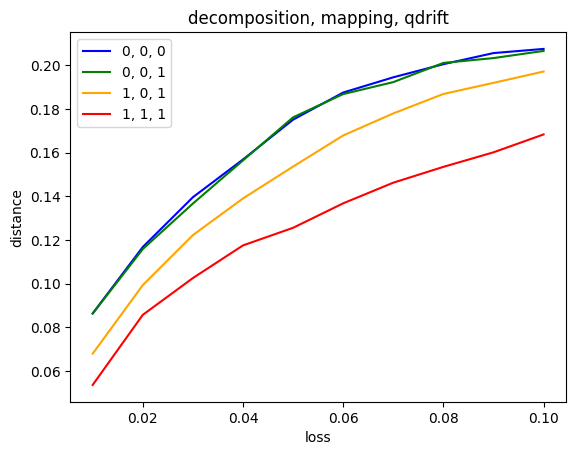

In [46]:
import matplotlib.pyplot as plt

x_axis = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]

# Plotting the lists
plt.plot(x_axis, G1_acc1, color='blue', label='0, 0, 0')
plt.plot(x_axis, G1_acc2, color='green', label='0, 0, 1')
plt.plot(x_axis, G1_acc3, color='orange', label='1, 0, 1')
plt.plot(x_axis, G1_acc4, color='red', label='1, 1, 1')

# Adding a legend and labels
plt.legend()
plt.xlabel('loss')
plt.ylabel('distance')
plt.title('decomposition, mapping, qdrift')

# Display the plot
plt.show()

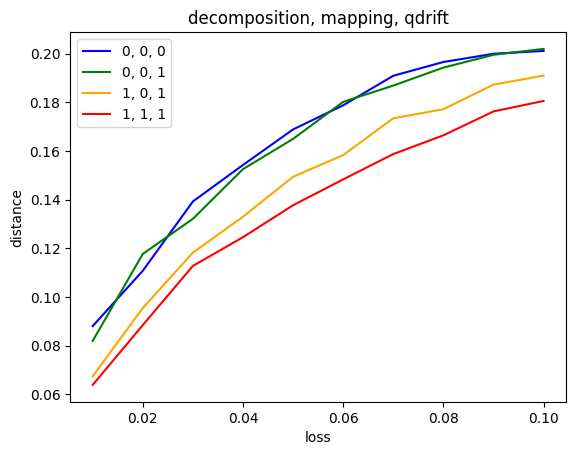

In [47]:
import matplotlib.pyplot as plt

x_axis = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
# Plotting the lists
plt.plot(x_axis, G2_acc1, color='blue', label='0, 0, 0')
plt.plot(x_axis, G2_acc2, color='green', label='0, 0, 1')
plt.plot(x_axis, G2_acc3, color='orange', label='1, 0, 1')
plt.plot(x_axis, G2_acc4, color='red', label='1, 1, 1')

# Adding a legend and labels
plt.legend()
plt.xlabel('loss')
plt.ylabel('distance')
plt.title('decomposition, mapping, qdrift')

# Display the plot
plt.show()

U1: 99.9%
e2 0.12,  0.9637681159420289
e3 0.056, 0.8115942028985508
e4 0.045, 0.7427536231884058

U2: 99.9%
e2 0.111, 0.9528985507246377
e3 0.058, 0.8333333333333334
e4 0.078, 0.7753623188405797

In [48]:
_, Theta1_00, Phi, Low_idx, High_idx, Diag, Permutation = U_decompose_plus(U1, dec_list1)
_, Theta2_00, Phi, Low_idx, High_idx, Diag, Permutation = U_decompose_plus(U2, dec_list1)
# create path for Theta1_00
path_Theta1_00 = 'Theta1_00.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta1_00, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta1_00)
    
# create path for Theta2_00
path_Theta2_00 = 'Theta2_00.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta2_00, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta2_00)

/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: invalid value encountered in scalar divide


In [49]:
_, Theta1_01, Phi, Low_idx, High_idx, Diag, Permutation = U_decompose_plus(U1, dec_list2)
_, Theta2_01, Phi, Low_idx, High_idx, Diag, Permutation = U_decompose_plus(U2, dec_list2)
# create path for Theta1_01
path_Theta1_01 = 'Theta1_01.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta1_01, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta1_01)
    
# create path for Theta2_01
path_Theta2_01 = 'Theta2_01.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta2_01, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta2_01)

/tmp/ipykernel_201138/370532848.py:22: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/370532848.py:25: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: invalid value encountered in scalar divide


In [50]:
U1_map, col_per_matrix, row_per_matrix = mapping(U1, len_list2, 12)
U2_map, col_per_matrix, row_per_matrix = mapping(U2, len_list2, 12)
_, Theta1_11, Phi, Low_idx, High_idx, Diag, Permutation = U_decompose_plus(U1_map, dec_list2)
_, Theta2_11, Phi, Low_idx, High_idx, Diag, Permutation = U_decompose_plus(U2_map, dec_list2)
# create path for Theta1_01
path_Theta1_11 = 'Theta1_11.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta1_11, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta1_11)
    
# create path for Theta2_11
path_Theta2_11 = 'Theta2_11.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta2_11, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta2_11)

/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_201138/370532848.py:22: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/370532848.py:25: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/370532848.py:22: RuntimeWarning: divide by zero encountered in scalar divide


In [51]:
U_map, col_per_matrix, row_per_matrix = mapping(U2, len_list2, 10)

In [52]:
_, Theta, Phi, Low_idx, High_idx, Diag, Permutation = U_decompose_plus(U_map, dec_list2)

/tmp/ipykernel_201138/370532848.py:22: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/370532848.py:25: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: divide by zero encountered in scalar divide


In [53]:
_, Theta, Phi, Low_idx, High_idx, Diag, Permutation = U_decompose_plus(U2, dec_list2)

/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:23: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/2223956829.py:26: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/370532848.py:22: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_201138/370532848.py:25: RuntimeWarning: invalid value encountered in scalar divide


In [54]:
new_Theta = make_entries_zero(Theta, 0.055)

In [55]:
np.count_nonzero(new_Theta)

225

In [56]:
np.count_nonzero(new_Theta)/276

0.8152173913043478

In [57]:
U_app = matrix_reconstruct(new_Theta, Phi, Low_idx, High_idx, Diag, Permutation, 24)

In [58]:
accuracy(U2,U_app)

(0.999067234456372+3.325388831891593e-11j)

In [59]:
accuracy(U_map,U_app)

(0.007733538873415225+0.012296267899384872j)

In [60]:
Theta_prob = calculate_probability_sequence(Theta, 0.27, 100)

In [61]:
new_Theta = pick_entries_with_indices(Theta, Theta_prob, 0.602)

In [62]:
np.count_nonzero(new_Theta)/276

0.6014492753623188

In [63]:
M = 1000
Acc = []
N = 20
Theta_prob = calculate_probability_sequence(Theta, 0.055, N)
for i in range(M):
    new_Theta = pick_entries_with_indices(Theta, Theta_prob, 0.758)
    if i == 0:
        print(np.count_nonzero(new_Theta))
    U_app = matrix_reconstruct(new_Theta, Phi, Low_idx, High_idx, Diag, Permutation, 24)
    acc = accuracy(U_map,U_app)
    Acc.append(acc)
    
np.array(Acc).mean()

209


(0.00678612625028288+0.0119494124535088j)